In [1]:
## Adapted from the GAN implementation in the PyTorch-GAN model zoo:
## https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

In [2]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
%matplotlib inline

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
os.makedirs('images', exist_ok=True)

n_epochs = 500 #'number of epochs of training'
batch_size = 64 #'size of the batches'
lr = 0.0002 #'adam: learning rate'
b1 = 0.5 #'adam: decay of first order momentum of gradient'
b2 = 0.999 #'adam: decay of first order momentum of gradient'
n_cpu = 4 #'number of cpu threads to use during batch generation'
latent_dim = 100 #'dimensionality of the latent space'
img_size = 28 #'size of each image dimension'
channels = 1 #'number of image channels'
sample_interval=400 #'interval betwen image samples'

In [4]:
torch.cuda.is_available()

True

In [5]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [7]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs('../../data/mnist', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [8]:
## useful functions for collecting triangle statistics

def triplet_sample(X):
    """
    given an array of images X, return a triplet
    """
    while True:
        [i,j,k] = list(np.random.randint(0, X.shape[0], 3))
        if len({i,j,k}) == 3:
            return [X[i], X[j], X[k]]
        
        
def distance_L2(x,y):
    """
    given 2 images, x, y, return the normalized l2 distance between them,
    normalized so that the max distance is 1
    """
    return np.sqrt(np.sum((x - y)**2))/56


def distance_H(x,y):
    """
    given 2 images, x, y, return the normalized Hamming distance between them,
    """
    x_binary = np.asarray(x.reshape(784)>0)
    y_binary = np.asarray(y.reshape(784)>0) 
    return np.count_nonzero(x_binary != y_binary)/len(x_binary)


def triangle_distances_l2(x,y,z):
    """
    return the sorted l2 distances of the triangle formed by the points (x,y,z)
    """
    return sorted([distance_L2(x,y), distance_L2(x,z), distance_L2(y,z)])


def triangle_distances_H(x,y,z):
    """
    return the sorted normalized Hamming distances of the triangle formed by the points (x,y,z)
    """
    return sorted([distance_H(x,y), distance_H(x,z), distance_H(y,z)])


def angles(dxy, dxz, dyz):
    """
    Given the 3 distances of a triangle, return the sorted angles
    """
    theta_xy = np.arccos((-dxy**2 + dxz**2 + dyz**2)/(2*dxz*dyz))
    theta_xz = np.arccos((dxy**2 - dxz**2 + dyz**2)/(2*dxy*dyz))
    theta_yz = np.arccos((dxy**2 + dxz**2 - dyz**2)/(2*dxy*dxz))
    return sorted([theta_xy, theta_xz, theta_yz])


def triangle_distributions(X, Num):
    """
    Given an array of samples 4, generate two arrays of shape (Num, 2).
    
    Array 1: the 2 dimensions are [dmid-dmin, dmax-dmid] (l2 distance)
    Array 2: the 2 dimensions are [theta_min/theta_max, theta_min/theta_mid] (l2 distance)
    Array 3: the 2 dimensions are [dmid-dmin, dmax-dmid] (Hamming distance)
    Array 4: the 2 dimensions are [theta_min/theta_max, theta_min/theta_mid] (Hamming distance)
    """

    K_distances_l2 = np.zeros((Num,2))
    K_angles_l2 = np.zeros((Num,2))
    K_distances_H = np.zeros((Num,2))
    K_angles_H = np.zeros((Num,2))
    
    for i in range(Num):
        [x, y, z] = triplet_sample(X)
        
        ## l2 distances
        [d_min, d_mid, d_max] = triangle_distances_l2(x,y,z)
        [theta_min, theta_mid, theta_max] = angles(d_min, d_mid, d_max)        

        K_distances_l2[i,0] = d_mid - d_min
        K_distances_l2[i,1] = d_max - d_mid        
        K_angles_l2[i,0] = theta_min/theta_mid
        K_angles_l2[i,1] = theta_min/theta_max

        ## Hamming distances
        [d_min, d_mid, d_max] = triangle_distances_l2(x,y,z)
        [theta_min, theta_mid, theta_max] = angles(d_min, d_mid, d_max)        

        K_distances_H[i,0] = d_mid - d_min
        K_distances_H[i,1] = d_max - d_mid        
        K_angles_H[i,0] = theta_min/theta_mid
        K_angles_H[i,1] = theta_min/theta_max

        
    return [K_distances_l2, K_angles_l2, K_distances_H, K_angles_H]

### Training

In [9]:
g_loss_list = []
d_loss_list = []
g_overlap_list = []
d_overlap_list = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        optimizer_G.zero_grad()
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        # Generate a batch of images
        gen_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
        # -----------------
        
        # ---------------------
        #  Train Discriminator
        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        # ---------------------

        # ---------------------
        # Monitor Progress
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:# and batches_done != 0:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % \
                   (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))
            
            batches_done_str = str(batches_done).zfill(8)
            
            ## save the losses
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            
            #----------------------
            # Generator Grad Overlap
            gen_imgs = generator(z)
 
            ## loss computed via built-in CE function
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            ## loss computed by scratch (needed to compute 2nd deriv)
            g_loss_homebrew = - torch.log(discriminator(gen_imgs)).mean()
            #print("g loss comparison: ", g_loss, g_loss_homebrew)
            
            ## this computes g_i, ||g||^2
            g_loss_grad = torch.autograd.grad(g_loss_homebrew, generator.parameters(), create_graph=True)
            g_loss_grad_norm_sq = 0
            for g in g_loss_grad:
                g_loss_grad_norm_sq = g_loss_grad_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H)_i, 4 ||H g||^2
            g_loss_grad2 = torch.autograd.grad(g_loss_grad_norm_sq, generator.parameters(), create_graph=True)
            g_loss_grad2_norm_sq = 0
            for g in g_loss_grad2:
                g_loss_grad2_norm_sq = g_loss_grad2_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H g)
            g_overlap_raw = 0
            for i in range(len(g_loss_grad2)):
                g_overlap_raw = g_overlap_raw + torch.mul(g_loss_grad[i], g_loss_grad2[i]).sum() 

            ## finally, compute the overlap (g^T H g)/(||g|| ||H g||)
            g_overlap = g_overlap_raw/torch.sqrt(g_loss_grad_norm_sq)/torch.sqrt(g_loss_grad2_norm_sq)
            g_overlap_list.append(g_overlap.data.cpu().numpy())
            #----------------------

            #----------------------
            # Discriminator Grad Overlap
            gen_imgs = generator(z)

            ## loss computed via built-in CE function
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            ## loss computed by scratch (needed to compute 2nd deriv)
            real_loss_homebrew = - torch.log(discriminator(real_imgs)).mean()
            fake_loss_homebrew = - torch.log(1.0-discriminator(gen_imgs.detach())).mean()
            d_loss_homebrew = (real_loss_homebrew + fake_loss_homebrew) / 2            
            #print("d loss comparison: ", d_loss, d_loss_homebrew)

            ## this computes g_i, ||g||^2
            d_loss_grad = torch.autograd.grad(g_loss_homebrew, discriminator.parameters(), create_graph=True)
            d_loss_grad_norm_sq = 0
            for g in d_loss_grad:
                d_loss_grad_norm_sq = d_loss_grad_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H)_i, 4 ||H g||^2
            d_loss_grad2 = torch.autograd.grad(d_loss_grad_norm_sq, discriminator.parameters(), create_graph=True)
            d_loss_grad2_norm_sq = 0
            for g in d_loss_grad2:
                d_loss_grad2_norm_sq = d_loss_grad2_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H g)
            d_overlap_raw = 0
            for i in range(len(d_loss_grad2)):
                d_overlap_raw = d_overlap_raw + torch.mul(d_loss_grad[i], d_loss_grad2[i]).sum() 

            ## finally, compute the overlap (g^T H g)/(||g|| ||H g||)
            d_overlap = d_overlap_raw/torch.sqrt(d_loss_grad_norm_sq)/torch.sqrt(d_loss_grad2_norm_sq)
            d_overlap_list.append(d_overlap.data.cpu().numpy())
            #----------------------

            ## print the overlaps
            print('g_overlap: %.3f, d_overlap: %.3f' % (g_overlap, d_overlap))

#             # plot a grid of samples
#             x = gen_imgs.data[:,0,:,:].cpu()
#             plt.figure(figsize=(6, 6))
#             plt.suptitle("Sampled Images, Batch_Num: " + str(batches_done), fontsize=16)
#             for j in range(64):
#                 plt.subplot(8, 8, j + 1)
#                 plt.imshow(x[j].reshape([28,28]), cmap='gray')
#                 plt.xticks(())
#                 plt.yticks(())
#             plt.savefig('images/sample_images_' + batches_done_str + '.png')
#             plt.close()
#             #plt.show()

#             Z = Variable(Tensor(np.random.normal(0, 1, (1000, latent_dim))))
#             gen_imgs = generator(Z)
#             X = gen_imgs.data[:,0,:,:].cpu().numpy()

#             [K_distances_l2, K_angles_l2, K_distances_H, K_angles_H] = triangle_distributions(X, 10000)
            
#             ## plot the 2d triangle distance density plot (l2 norm)
#             fig,ax = plt.subplots(1,1)
#             ax1 = sns.kdeplot(K_distances_l2[:,0], K_distances_l2[:,1])
#             ax1.set_xlim([0, 1.0])
#             ax1.set_ylim([0, 1.0])
#             ax1.set_xlabel(r"$d_{mid}-d_{min}$", fontsize=16)
#             ax1.set_ylabel(r"$d_{max}-d_{mid}$", fontsize=16)
#             ax1.set_title("Distance Density Plot (l2 distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/distance_plot_l2_' + batches_done_str + '.png')
#             plt.close()
#             #plt.show()
            
#             ## plot the 2d triangle angle density plot (l2 norm)
#             fig,ax = plt.subplots(1,1)
#             ax2 = sns.kdeplot(K_angles_l2[:,0], K_angles_l2[:,1])
#             ax2.set_xlim([0, 1.0])
#             ax2.set_ylim([0, 1.0])
#             ax2.set_xlabel(r"$\theta_{min}/\theta_{mid}$", fontsize=16)
#             ax2.set_ylabel(r"$\theta_{min}/\theta_{max}$", fontsize=16)
#             ax2.set_title("Angle Density Plot (l2 distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/triangle_plot_l2_' + batches_done_str + '.png')
#             plt.close()            
#             #plt.show()
    
#             ## plot the 2d triangle distance density plot (H norm)
#             fig,ax = plt.subplots(1,1)
#             ax1 = sns.kdeplot(K_distances_H[:,0], K_distances_H[:,1])
#             ax1.set_xlim([0, 1.0])
#             ax1.set_ylim([0, 1.0])
#             ax1.set_xlabel(r"$d_{mid}-d_{min}$", fontsize=16)
#             ax1.set_ylabel(r"$d_{max}-d_{mid}$", fontsize=16)
#             ax1.set_title("Distance Density Plot (H distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/distance_plot_H_' + batches_done_str + '.png')
#             plt.close()
#             #plt.show()
            
#             ## plot the 2d triangle angle density plot (H norm)
#             fig,ax = plt.subplots(1,1)
#             ax2 = sns.kdeplot(K_angles_H[:,0], K_angles_H[:,1])
#             ax2.set_xlim([0, 1.0])
#             ax2.set_ylim([0, 1.0])
#             ax2.set_xlabel(r"$\theta_{min}/\theta_{mid}$", fontsize=16)
#             ax2.set_ylabel(r"$\theta_{min}/\theta_{max}$", fontsize=16)
#             ax2.set_title("Angle Density Plot (H distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/triangle_plot_H_' + batches_done_str + '.png')
#             plt.close()            
#             #plt.show()
        #torch.cuda.empty_cache()
        # ---------------------

[Epoch 0/500] [Batch 0/938] [D loss: 0.707259] [G loss: 0.668523]
g_overlap: 0.266, d_overlap: 0.754
[Epoch 0/500] [Batch 400/938] [D loss: 0.286365] [G loss: 1.687410]
g_overlap: 0.805, d_overlap: 0.976
[Epoch 0/500] [Batch 800/938] [D loss: 0.424851] [G loss: 0.612549]
g_overlap: 0.136, d_overlap: 0.897
[Epoch 1/500] [Batch 262/938] [D loss: 0.196895] [G loss: 1.965968]
g_overlap: 0.903, d_overlap: 0.998
[Epoch 1/500] [Batch 662/938] [D loss: 0.163063] [G loss: 2.102900]
g_overlap: 0.878, d_overlap: 0.992
[Epoch 2/500] [Batch 124/938] [D loss: 0.240094] [G loss: 1.417041]
g_overlap: 0.845, d_overlap: 0.994
[Epoch 2/500] [Batch 524/938] [D loss: 0.307234] [G loss: 0.958277]
g_overlap: 0.546, d_overlap: 0.979
[Epoch 2/500] [Batch 924/938] [D loss: 0.280707] [G loss: 1.145912]
g_overlap: 0.503, d_overlap: 0.973
[Epoch 3/500] [Batch 386/938] [D loss: 0.331143] [G loss: 1.075031]
g_overlap: 0.530, d_overlap: 0.968
[Epoch 3/500] [Batch 786/938] [D loss: 0.132372] [G loss: 2.413798]
g_overl

[Epoch 34/500] [Batch 108/938] [D loss: 0.179562] [G loss: 2.273086]
g_overlap: 0.538, d_overlap: 0.989
[Epoch 34/500] [Batch 508/938] [D loss: 0.257978] [G loss: 1.354555]
g_overlap: 0.188, d_overlap: 0.959
[Epoch 34/500] [Batch 908/938] [D loss: 0.300404] [G loss: 2.224271]
g_overlap: 0.446, d_overlap: 0.982
[Epoch 35/500] [Batch 370/938] [D loss: 0.284697] [G loss: 1.251750]
g_overlap: 0.293, d_overlap: 0.632
[Epoch 35/500] [Batch 770/938] [D loss: 0.242308] [G loss: 2.092873]
g_overlap: 0.304, d_overlap: 0.978
[Epoch 36/500] [Batch 232/938] [D loss: 0.172558] [G loss: 2.305048]
g_overlap: 0.505, d_overlap: 0.987
[Epoch 36/500] [Batch 632/938] [D loss: 0.275573] [G loss: 1.761249]
g_overlap: 0.555, d_overlap: 0.984
[Epoch 37/500] [Batch 94/938] [D loss: 0.191316] [G loss: 2.839485]
g_overlap: 0.467, d_overlap: 0.980
[Epoch 37/500] [Batch 494/938] [D loss: 0.282417] [G loss: 1.759132]
g_overlap: 0.046, d_overlap: 0.977
[Epoch 37/500] [Batch 894/938] [D loss: 0.259656] [G loss: 1.8539

[Epoch 67/500] [Batch 754/938] [D loss: 0.335124] [G loss: 2.267268]
g_overlap: 0.703, d_overlap: 0.981
[Epoch 68/500] [Batch 216/938] [D loss: 0.335555] [G loss: 3.127644]
g_overlap: 0.279, d_overlap: 0.985
[Epoch 68/500] [Batch 616/938] [D loss: 0.303830] [G loss: 2.219358]
g_overlap: 0.320, d_overlap: 0.967
[Epoch 69/500] [Batch 78/938] [D loss: 0.373046] [G loss: 1.689226]
g_overlap: 0.579, d_overlap: 0.988
[Epoch 69/500] [Batch 478/938] [D loss: 0.222566] [G loss: 2.516386]
g_overlap: 0.548, d_overlap: 0.983
[Epoch 69/500] [Batch 878/938] [D loss: 0.429159] [G loss: 1.181023]
g_overlap: 0.342, d_overlap: 0.966
[Epoch 70/500] [Batch 340/938] [D loss: 0.270463] [G loss: 2.035870]
g_overlap: 0.462, d_overlap: 0.979
[Epoch 70/500] [Batch 740/938] [D loss: 0.181475] [G loss: 2.211879]
g_overlap: 0.510, d_overlap: 0.983
[Epoch 71/500] [Batch 202/938] [D loss: 0.297476] [G loss: 2.102029]
g_overlap: 0.559, d_overlap: 0.987
[Epoch 71/500] [Batch 602/938] [D loss: 0.216381] [G loss: 1.7660

[Epoch 101/500] [Batch 462/938] [D loss: 0.340563] [G loss: 4.043537]
g_overlap: 0.232, d_overlap: 0.969
[Epoch 101/500] [Batch 862/938] [D loss: 0.289450] [G loss: 2.748381]
g_overlap: 0.356, d_overlap: 0.972
[Epoch 102/500] [Batch 324/938] [D loss: 0.234571] [G loss: 2.363770]
g_overlap: 0.492, d_overlap: 0.981
[Epoch 102/500] [Batch 724/938] [D loss: 0.219730] [G loss: 2.209042]
g_overlap: 0.343, d_overlap: 0.967
[Epoch 103/500] [Batch 186/938] [D loss: 0.223149] [G loss: 2.107952]
g_overlap: 0.262, d_overlap: 0.968
[Epoch 103/500] [Batch 586/938] [D loss: 0.374986] [G loss: 1.756645]
g_overlap: 0.643, d_overlap: 0.967
[Epoch 104/500] [Batch 48/938] [D loss: 0.252705] [G loss: 1.974776]
g_overlap: -0.030, d_overlap: 0.975
[Epoch 104/500] [Batch 448/938] [D loss: 0.383355] [G loss: 2.355662]
g_overlap: 0.637, d_overlap: 0.977
[Epoch 104/500] [Batch 848/938] [D loss: 0.204490] [G loss: 2.025456]
g_overlap: 0.183, d_overlap: 0.982
[Epoch 105/500] [Batch 310/938] [D loss: 0.259908] [G l

[Epoch 135/500] [Batch 170/938] [D loss: 0.297085] [G loss: 1.514917]
g_overlap: 0.310, d_overlap: 0.981
[Epoch 135/500] [Batch 570/938] [D loss: 0.265168] [G loss: 2.327313]
g_overlap: 0.464, d_overlap: 0.960
[Epoch 136/500] [Batch 32/938] [D loss: 0.279552] [G loss: 2.045164]
g_overlap: 0.488, d_overlap: 0.990
[Epoch 136/500] [Batch 432/938] [D loss: 0.374920] [G loss: 2.291800]
g_overlap: 0.486, d_overlap: 0.976
[Epoch 136/500] [Batch 832/938] [D loss: 0.347251] [G loss: 1.493723]
g_overlap: 0.319, d_overlap: 0.971
[Epoch 137/500] [Batch 294/938] [D loss: 0.301767] [G loss: 1.823380]
g_overlap: 0.218, d_overlap: 0.975
[Epoch 137/500] [Batch 694/938] [D loss: 0.333895] [G loss: 2.236982]
g_overlap: 0.353, d_overlap: 0.959
[Epoch 138/500] [Batch 156/938] [D loss: 0.434787] [G loss: 1.592079]
g_overlap: 0.699, d_overlap: 0.986
[Epoch 138/500] [Batch 556/938] [D loss: 0.273099] [G loss: 2.013300]
g_overlap: 0.205, d_overlap: 0.984
[Epoch 139/500] [Batch 18/938] [D loss: 0.298786] [G los

[Epoch 168/500] [Batch 816/938] [D loss: 0.242442] [G loss: 2.576180]
g_overlap: 0.395, d_overlap: 0.962
[Epoch 169/500] [Batch 278/938] [D loss: 0.172985] [G loss: 1.829342]
g_overlap: 0.424, d_overlap: 0.958
[Epoch 169/500] [Batch 678/938] [D loss: 0.252625] [G loss: 1.934685]
g_overlap: 0.038, d_overlap: 0.971
[Epoch 170/500] [Batch 140/938] [D loss: 0.274057] [G loss: 1.896125]
g_overlap: 0.150, d_overlap: 0.961
[Epoch 170/500] [Batch 540/938] [D loss: 0.379462] [G loss: 2.056871]
g_overlap: 0.268, d_overlap: 0.980
[Epoch 171/500] [Batch 2/938] [D loss: 0.349317] [G loss: 1.844360]
g_overlap: 0.524, d_overlap: 0.962
[Epoch 171/500] [Batch 402/938] [D loss: 0.225265] [G loss: 2.057137]
g_overlap: 0.530, d_overlap: 0.908
[Epoch 171/500] [Batch 802/938] [D loss: 0.359071] [G loss: 2.133596]
g_overlap: 0.018, d_overlap: 0.974
[Epoch 172/500] [Batch 264/938] [D loss: 0.325131] [G loss: 2.198963]
g_overlap: 0.332, d_overlap: 0.966
[Epoch 172/500] [Batch 664/938] [D loss: 0.347295] [G los

[Epoch 202/500] [Batch 524/938] [D loss: 0.259371] [G loss: 1.832942]
g_overlap: 0.403, d_overlap: 0.960
[Epoch 202/500] [Batch 924/938] [D loss: 0.219034] [G loss: 2.432658]
g_overlap: 0.663, d_overlap: 0.975
[Epoch 203/500] [Batch 386/938] [D loss: 0.259494] [G loss: 1.881791]
g_overlap: 0.006, d_overlap: 0.964
[Epoch 203/500] [Batch 786/938] [D loss: 0.325529] [G loss: 2.204315]
g_overlap: 0.522, d_overlap: 0.945
[Epoch 204/500] [Batch 248/938] [D loss: 0.267084] [G loss: 2.009570]
g_overlap: 0.553, d_overlap: 0.929
[Epoch 204/500] [Batch 648/938] [D loss: 0.252596] [G loss: 2.045604]
g_overlap: 0.561, d_overlap: 0.957
[Epoch 205/500] [Batch 110/938] [D loss: 0.288302] [G loss: 2.178234]
g_overlap: 0.294, d_overlap: 0.965
[Epoch 205/500] [Batch 510/938] [D loss: 0.285308] [G loss: 1.905596]
g_overlap: 0.532, d_overlap: 0.954
[Epoch 205/500] [Batch 910/938] [D loss: 0.195487] [G loss: 1.770241]
g_overlap: 0.389, d_overlap: 0.928
[Epoch 206/500] [Batch 372/938] [D loss: 0.225024] [G l

[Epoch 236/500] [Batch 232/938] [D loss: 0.290115] [G loss: 1.993653]
g_overlap: 0.208, d_overlap: 0.907
[Epoch 236/500] [Batch 632/938] [D loss: 0.442265] [G loss: 2.321935]
g_overlap: 0.550, d_overlap: 0.973
[Epoch 237/500] [Batch 94/938] [D loss: 0.330755] [G loss: 2.324135]
g_overlap: 0.479, d_overlap: 0.908
[Epoch 237/500] [Batch 494/938] [D loss: 0.264429] [G loss: 2.334942]
g_overlap: 0.685, d_overlap: 0.932
[Epoch 237/500] [Batch 894/938] [D loss: 0.332873] [G loss: 1.865200]
g_overlap: 0.560, d_overlap: 0.956
[Epoch 238/500] [Batch 356/938] [D loss: 0.321217] [G loss: 1.694567]
g_overlap: 0.473, d_overlap: 0.958
[Epoch 238/500] [Batch 756/938] [D loss: 0.348045] [G loss: 1.949947]
g_overlap: 0.331, d_overlap: 0.949
[Epoch 239/500] [Batch 218/938] [D loss: 0.319694] [G loss: 1.873505]
g_overlap: 0.713, d_overlap: 0.884
[Epoch 239/500] [Batch 618/938] [D loss: 0.288184] [G loss: 1.728447]
g_overlap: 0.537, d_overlap: 0.973
[Epoch 240/500] [Batch 80/938] [D loss: 0.319068] [G los

[Epoch 269/500] [Batch 878/938] [D loss: 0.232936] [G loss: 2.079826]
g_overlap: 0.430, d_overlap: 0.937
[Epoch 270/500] [Batch 340/938] [D loss: 0.242032] [G loss: 2.027682]
g_overlap: 0.557, d_overlap: 0.948
[Epoch 270/500] [Batch 740/938] [D loss: 0.342256] [G loss: 2.243754]
g_overlap: 0.665, d_overlap: 0.932
[Epoch 271/500] [Batch 202/938] [D loss: 0.331895] [G loss: 1.715506]
g_overlap: 0.701, d_overlap: 0.898
[Epoch 271/500] [Batch 602/938] [D loss: 0.258090] [G loss: 1.749839]
g_overlap: 0.464, d_overlap: 0.969
[Epoch 272/500] [Batch 64/938] [D loss: 0.329425] [G loss: 2.008627]
g_overlap: 0.475, d_overlap: 0.935
[Epoch 272/500] [Batch 464/938] [D loss: 0.338173] [G loss: 1.584256]
g_overlap: 0.536, d_overlap: 0.962
[Epoch 272/500] [Batch 864/938] [D loss: 0.419637] [G loss: 2.022569]
g_overlap: 0.422, d_overlap: 0.971
[Epoch 273/500] [Batch 326/938] [D loss: 0.321411] [G loss: 1.345594]
g_overlap: 0.440, d_overlap: 0.950
[Epoch 273/500] [Batch 726/938] [D loss: 0.312892] [G lo

[Epoch 303/500] [Batch 586/938] [D loss: 0.400912] [G loss: 1.677908]
g_overlap: 0.575, d_overlap: 0.962
[Epoch 304/500] [Batch 48/938] [D loss: 0.368929] [G loss: 1.351969]
g_overlap: 0.606, d_overlap: 0.960
[Epoch 304/500] [Batch 448/938] [D loss: 0.299799] [G loss: 1.910064]
g_overlap: 0.636, d_overlap: 0.968
[Epoch 304/500] [Batch 848/938] [D loss: 0.357056] [G loss: 1.931121]
g_overlap: 0.499, d_overlap: 0.941
[Epoch 305/500] [Batch 310/938] [D loss: 0.336729] [G loss: 1.841105]
g_overlap: 0.414, d_overlap: 0.961
[Epoch 305/500] [Batch 710/938] [D loss: 0.371461] [G loss: 1.817461]
g_overlap: 0.537, d_overlap: 0.969
[Epoch 306/500] [Batch 172/938] [D loss: 0.311549] [G loss: 1.587832]
g_overlap: 0.483, d_overlap: 0.935
[Epoch 306/500] [Batch 572/938] [D loss: 0.345887] [G loss: 1.636019]
g_overlap: -0.283, d_overlap: 0.958
[Epoch 307/500] [Batch 34/938] [D loss: 0.290981] [G loss: 1.802900]
g_overlap: 0.729, d_overlap: 0.899
[Epoch 307/500] [Batch 434/938] [D loss: 0.286017] [G lo

[Epoch 337/500] [Batch 294/938] [D loss: 0.303933] [G loss: 1.777005]
g_overlap: 0.443, d_overlap: 0.945
[Epoch 337/500] [Batch 694/938] [D loss: 0.286719] [G loss: 1.615305]
g_overlap: 0.569, d_overlap: 0.954
[Epoch 338/500] [Batch 156/938] [D loss: 0.443391] [G loss: 1.648029]
g_overlap: 0.746, d_overlap: 0.936
[Epoch 338/500] [Batch 556/938] [D loss: 0.329546] [G loss: 1.252887]
g_overlap: 0.645, d_overlap: 0.958
[Epoch 339/500] [Batch 18/938] [D loss: 0.354435] [G loss: 1.443572]
g_overlap: 0.664, d_overlap: 0.956
[Epoch 339/500] [Batch 418/938] [D loss: 0.324697] [G loss: 1.910793]
g_overlap: 0.527, d_overlap: 0.940
[Epoch 339/500] [Batch 818/938] [D loss: 0.357618] [G loss: 1.447282]
g_overlap: 0.533, d_overlap: 0.959
[Epoch 340/500] [Batch 280/938] [D loss: 0.276610] [G loss: 2.123323]
g_overlap: 0.482, d_overlap: 0.935
[Epoch 340/500] [Batch 680/938] [D loss: 0.316209] [G loss: 1.481976]
g_overlap: 0.404, d_overlap: 0.953
[Epoch 341/500] [Batch 142/938] [D loss: 0.335327] [G lo

[Epoch 371/500] [Batch 2/938] [D loss: 0.283612] [G loss: 2.420693]
g_overlap: 0.622, d_overlap: 0.910
[Epoch 371/500] [Batch 402/938] [D loss: 0.287045] [G loss: 2.190467]
g_overlap: 0.521, d_overlap: 0.955
[Epoch 371/500] [Batch 802/938] [D loss: 0.395645] [G loss: 1.647275]
g_overlap: 0.587, d_overlap: 0.919
[Epoch 372/500] [Batch 264/938] [D loss: 0.324071] [G loss: 1.571171]
g_overlap: 0.521, d_overlap: 0.935
[Epoch 372/500] [Batch 664/938] [D loss: 0.359649] [G loss: 1.710121]
g_overlap: 0.030, d_overlap: 0.918
[Epoch 373/500] [Batch 126/938] [D loss: 0.311547] [G loss: 1.636437]
g_overlap: 0.571, d_overlap: 0.895
[Epoch 373/500] [Batch 526/938] [D loss: 0.307974] [G loss: 1.761383]
g_overlap: 0.672, d_overlap: 0.950
[Epoch 373/500] [Batch 926/938] [D loss: 0.417292] [G loss: 1.463850]
g_overlap: 0.547, d_overlap: 0.955
[Epoch 374/500] [Batch 388/938] [D loss: 0.444207] [G loss: 1.853753]
g_overlap: 0.688, d_overlap: 0.981
[Epoch 374/500] [Batch 788/938] [D loss: 0.330461] [G los

[Epoch 404/500] [Batch 648/938] [D loss: 0.290799] [G loss: 1.964392]
g_overlap: 0.592, d_overlap: 0.900
[Epoch 405/500] [Batch 110/938] [D loss: 0.341325] [G loss: 1.825657]
g_overlap: 0.588, d_overlap: 0.952
[Epoch 405/500] [Batch 510/938] [D loss: 0.348586] [G loss: 1.711723]
g_overlap: 0.599, d_overlap: 0.955
[Epoch 405/500] [Batch 910/938] [D loss: 0.316808] [G loss: 1.663998]
g_overlap: 0.703, d_overlap: 0.940
[Epoch 406/500] [Batch 372/938] [D loss: 0.259938] [G loss: 1.746931]
g_overlap: 0.415, d_overlap: 0.949
[Epoch 406/500] [Batch 772/938] [D loss: 0.374586] [G loss: 1.888533]
g_overlap: 0.614, d_overlap: 0.954
[Epoch 407/500] [Batch 234/938] [D loss: 0.372847] [G loss: 1.824986]
g_overlap: 0.696, d_overlap: 0.949
[Epoch 407/500] [Batch 634/938] [D loss: 0.294561] [G loss: 1.758341]
g_overlap: 0.573, d_overlap: 0.950
[Epoch 408/500] [Batch 96/938] [D loss: 0.360049] [G loss: 1.898332]
g_overlap: 0.621, d_overlap: 0.975
[Epoch 408/500] [Batch 496/938] [D loss: 0.307585] [G lo

[Epoch 438/500] [Batch 356/938] [D loss: 0.396688] [G loss: 1.367253]
g_overlap: 0.686, d_overlap: 0.959
[Epoch 438/500] [Batch 756/938] [D loss: 0.380750] [G loss: 1.942936]
g_overlap: 0.521, d_overlap: 0.934
[Epoch 439/500] [Batch 218/938] [D loss: 0.300683] [G loss: 1.854701]
g_overlap: 0.578, d_overlap: 0.962
[Epoch 439/500] [Batch 618/938] [D loss: 0.377278] [G loss: 1.865578]
g_overlap: 0.624, d_overlap: 0.952
[Epoch 440/500] [Batch 80/938] [D loss: 0.287775] [G loss: 1.854321]
g_overlap: 0.583, d_overlap: 0.958
[Epoch 440/500] [Batch 480/938] [D loss: 0.253503] [G loss: 1.903507]
g_overlap: 0.557, d_overlap: 0.948
[Epoch 440/500] [Batch 880/938] [D loss: 0.398103] [G loss: 1.924913]
g_overlap: -0.164, d_overlap: 0.954
[Epoch 441/500] [Batch 342/938] [D loss: 0.356737] [G loss: 1.957384]
g_overlap: 0.624, d_overlap: 0.941
[Epoch 441/500] [Batch 742/938] [D loss: 0.268021] [G loss: 1.966944]
g_overlap: 0.448, d_overlap: 0.965
[Epoch 442/500] [Batch 204/938] [D loss: 0.364152] [G l

[Epoch 472/500] [Batch 64/938] [D loss: 0.314257] [G loss: 1.909029]
g_overlap: 0.579, d_overlap: 0.933
[Epoch 472/500] [Batch 464/938] [D loss: 0.287440] [G loss: 2.315327]
g_overlap: 0.238, d_overlap: 0.927
[Epoch 472/500] [Batch 864/938] [D loss: 0.335824] [G loss: 1.570916]
g_overlap: 0.587, d_overlap: 0.950
[Epoch 473/500] [Batch 326/938] [D loss: 0.314104] [G loss: 2.154517]
g_overlap: 0.350, d_overlap: 0.942
[Epoch 473/500] [Batch 726/938] [D loss: 0.348963] [G loss: 2.172601]
g_overlap: 0.669, d_overlap: 0.950
[Epoch 474/500] [Batch 188/938] [D loss: 0.261855] [G loss: 1.943872]
g_overlap: 0.707, d_overlap: 0.952
[Epoch 474/500] [Batch 588/938] [D loss: 0.357956] [G loss: 2.545326]
g_overlap: 0.586, d_overlap: 0.952
[Epoch 475/500] [Batch 50/938] [D loss: 0.292701] [G loss: 1.858169]
g_overlap: 0.473, d_overlap: 0.931
[Epoch 475/500] [Batch 450/938] [D loss: 0.286198] [G loss: 1.710045]
g_overlap: 0.650, d_overlap: 0.949
[Epoch 475/500] [Batch 850/938] [D loss: 0.306336] [G los

I want to be able to get the top eigenvalues of the Hessian. According to the Gur-Ari et al paper, the best way to do this is the Lanczos algorithm. I want to poke around a bit and see if there is a way to use an existing implementation of this; otherwise I will have to code it up myself. It doesn't seem too complicated, but from first appearances there are some subtle numerical stability issues that I'm not really excited to deal with. 

Also, I should note that as it stands now, I am computing the gradients and overlap wrt a minibatch, not the full-batch. This is not what Gur-Ari do, and the small batch size may introduce significant error. 

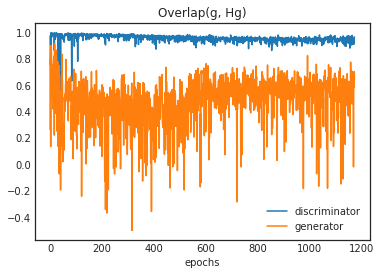

In [10]:
plt.plot(d_overlap_list, label='discriminator')
plt.plot(g_overlap_list, label='generator')
plt.title('Overlap(g, Hg)')
plt.xlabel('epochs')
plt.legend()
plt.show()

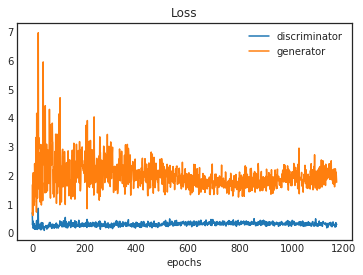

In [11]:
plt.plot(d_loss_list, label='discriminator')
plt.plot(g_loss_list, label='generator')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.show()